# Reconocimiento de Patrones
[Curso de Reconocimiento de Patrones]

Departamento Electrónia

Universidad Popular del Cesar

José Ramón Iglesias Gamarra

---

# Ejemplo: Extracción de Descriptores de Fourier

En este ejemplo se muestra cómo usar los Descriptores de Fourier para separar figuras geométricas  con formas distintas.

Referencias:

* [Paper sobre Descriptores de Fourier](https://www.dropbox.com/s/wlgrdiblcxgyk01/Fourier_Descriptors.pdf?dl=0)




# Setup inicial

Liberías necesarias para que funcione el algoritmo.

## Instalación de PyXvis

PyXvis es una librería creada recientemente para el libro [Computer Vision for X-ray Testing](https://domingomery.ing.puc.cl/publications/book/) (Mery & Pieringer, Springer, 2021). En los ejemplos de este notebook, se utiliza esta librería sólo para la extracción de características. Por el momento. como la instalación de PyXvis usando 'pip install pyxvis' es inestable, usaremos esta instalación: 

In [ ]:
# Instalación de PyXvis

!wget https://www.dropbox.com/s/54jfodpv1h4d0kl/pyxvis.zip
!unzip pyxvis.zip
!rm pyxvis.zip
print('PyXvis library downloaded.')
!pip install scipy==1.2
!pip3 install pybalu==0.2.5
!pip install ./pyxvis
print('PyXvis library installed.')


## Setup de librerías

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from   pyxvis.features.extraction import extract_features
from   pyxvis.io.plots import plot_features

# Ejemplo: Reconocimiento de 4 caracteres

En este ejemplo se realiza la extracción de características necesarias para realizar un reconocimiento de los siguientes cuatro caracterescon diversos tamaños y diversas orientaciones. 

* Clase 0: punto '.'

* Clase 1: tilde '~'

* Clase 3: asterisco '*'

* Clase 4: coma ',' 

Para la solución se utiliza los descriptores ya que son invariantes a la rotación y a la escala. 

En este ejemplo no se realiza la clasificación, sólo se muestra la extracción de descriptores de Fourier.



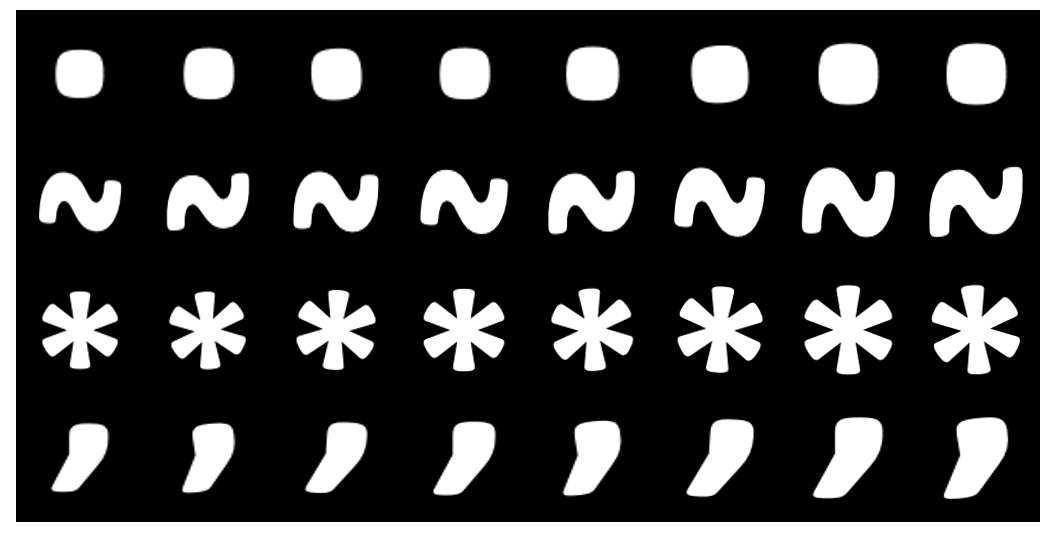

# Carga de base de datos

La base de datos consiste en 4 clases y 30 imágenes por clase

In [ ]:
# Carga de base de datos
!wget https://www.dropbox.com/s/zuczvajdrvrhs32/chars.zip
!unzip chars.zip

# Funciones necesarias

In [ ]:
def num2fixstr(x,d):
  # example num2fixstr(2,5) returns '00002'
  # example num2fixstr(19,3) returns '019'
  st = '%0*d' % (d,x)
  return st

def ImageLoad(prefix,num_char,num_img,echo='off'):
  # img = ImageLoad('example/char_',1,3)   loads image 'example/char_01_003.png'
  # img = ImageLoad('example/char_',2,15)  loads image 'example/char_02_015.png'
  st   = prefix + num2fixstr(num_char,2) + '_' + num2fixstr(num_img,3) + '.png'
  if echo == 'on':
    print('loading image '+st+'...')
  img    = plt.imread(st)
  return img

# Extracción de Descriptores de Fourier

In [ ]:
K = 4  # número de clases
N = 30 # número de imágenes por clase

fx = ['fourierdes']                      # características a extraer 
M  = 16                                  # los descriptores son 16

# si se quiere usar momentos de Flusser se puede usar fx = ['flusser'] y M = 4

X = np.zeros((K*N,M))               # K x N muestras (filas), y M características (columnas)
y = np.zeros((K*N,))                # ground truth (clasificacion ideal)

t = 0
for j in range(K):                  # para cada clase
  for i in range(N):                # para cada imagen de la clase
    # Lectura de la imagen
    img    = ImageLoad('chars/char_',j+1,i+1,echo='on')
    # Extracción de características
    R      = (img>0.5)*1            # segmentation
    f = extract_features(fx,bw=R)   # feature extraction
    f = f/np.linalg.norm(f)         # normalizacion

    X[t,:] = f
    y[t] = j
    t = t+1


# Visualización de distribución de clases

In [ ]:
f1 = 3  # Descriptor de Fourier f1
f2 = 5  # Descriptor de Fourier f2

print('Descriptores de Fourier: '+str((f1,f2)))

Xs = X[:,[f1,f2]]

plot_features(Xs,y,'Descriptores Fourier',show=1)


Del gráfico anterior, se puede pensar que un clasificador podría ser el siguiente:

* si x2 es mayor que 0.6 entonces es clase 2

* en caso contrario, si x1 es menor que 0.3 entonces es clase 3

* en caso contrario, si x1 es mayor que 0.6 entonces es clase 0

* en caso contrario es clase 1

# Matriz de similitud

Como cada caracter ha sido descrito como un vector (de 16 elementos) de norma uno, se puede realizar un producto punto de todos con todos. De esta manera los productos que sean cercanos a 1 indican que esos vectores son similares.

En esste ejemplo, en la matriz X de 120x16 elementos, existen 30 vectores por cada caracter, de esta manera los productos punto entre vectores de la misma clase deben dar cercanos a 1 (toda la diagonal es 1.0), mientras que los productos punto de vectores entre distintas clases deben dar valores mucho menores que 1. Se observa que la clase 3 con la clase 1, sin embargo, entrega vectores similares (el producto punto es aprox. 0.84).

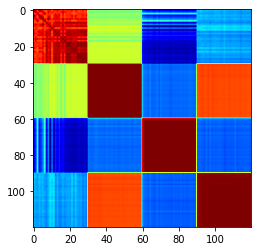

In [ ]:
D =  np.dot(X,X.T)
fig    = plt.figure()
ax     = fig.add_subplot(111)
implot = plt.imshow(D,cmap='jet') 

En este mapa de calor, colores parecidos al rojo indican valores cercanos a 1, mientras que colores cercanos al azul indican valores cercanos a 0.

Un clasificador podría diseñarse usando vecinos más cercanos, es decir para una nueva imagen de testing, se extrae el vector de Fourier normalizado en 1, se hace el producto punto con todas las filas de X y se escoge aquella clase de la mayoría de votos de las k muestras más similares de X.